# Implementation Tasks

1. **Quantization Exploration (Tutorial 3)**
   - In Tutorial 3, you quantized every Linear layer in the model to the provided configuration. Now, explore a range of fixed point widths from 4 to 32.  
   - Plot a figure where:
     - **x-axis:** Fixed point width  
     - **y-axis:** Highest achieved accuracy on the IMDb dataset  
     - Follow the procedure in Tutorial 3.  
   - Plot separate curves for **PTQ** and **QAT** at each precision to show the effect of post-quantization finetuning.

2. **Pruning Exploration (Tutorial 4)**
   - Take your best obtained model from Task 1 and rerun the pruning procedure, varying the sparsity from 0.1 to 0.9.  
   - Plot a figure where:
     - **x-axis:** Sparsity  
     - **y-axis:** Highest achieved accuracy on the IMDb dataset  
     - Follow the procedure in Tutorial 4.  
   - Plot separate curves for **Random** and **L1-Norm** methods to evaluate the effect of different pruning strategies.


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

In [3]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

In [5]:
from pathlib import Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")

/home/jw3621/adls/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loade

In [6]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/home/jw3621/adls/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.8136


## Task1

In [14]:
import chop.passes as passes
import copy


quant_config_search = []
bit_widths = [4, 8, 16, 32]

for width in bit_widths:
    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": width,
                "data_in_frac_width": width//2,
                # weight
                "weight_width": width,
                "weight_frac_width": width//2,
                # bias
                "bias_width": width,
                "bias_frac_width": width//2,
            }
        },
    }
    quant_config_search.append(copy.deepcopy(quantization_config))


### PTQ & QAT

In [15]:
ptq_accuracies = []
qat_accuracies = []


for width, config in zip(bit_widths, quant_config_search):
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")
    # Post-Training Quantization
    mg, _ = passes.quantize_transform_pass(
        mg,
        pass_args=config,
    )

    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )

    eval_results = trainer.evaluate()
    print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
    ptq_accuracies.append(eval_results["eval_accuracy"])

    # Quantization-Aware Training
    # Evaluate accuracy
    trainer.train()
    eval_results = trainer.evaluate()
    print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
    qat_accuracies.append(eval_results["eval_accuracy"])

/home/jw3621/adls/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loade

Evaluation accuracy: 0.5


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


/home/jw3621/adls/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loade

Evaluation accuracy: 0.5


/home/jw3621/adls/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.76104


Step,Training Loss
500,0.449800
1000,0.438200
1500,0.440500
2000,0.405800
2500,0.408200
3000,0.402500


/home/jw3621/adls/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loade

Evaluation accuracy: 0.83476


/home/jw3621/adls/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.81388


Step,Training Loss
500,0.439500
1000,0.428600
1500,0.433600
2000,0.395100
2500,0.398600
3000,0.395600


/home/jw3621/adls/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loade

Evaluation accuracy: 0.83472


/home/jw3621/adls/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.81356


Step,Training Loss
500,0.438600
1000,0.428300
1500,0.432000
2000,0.394900
2500,0.399400
3000,0.394800


Evaluation accuracy: 0.83512


[0.5, 0.76104, 0.81388, 0.81356]
[0.5, 0.83476, 0.83472, 0.83512]


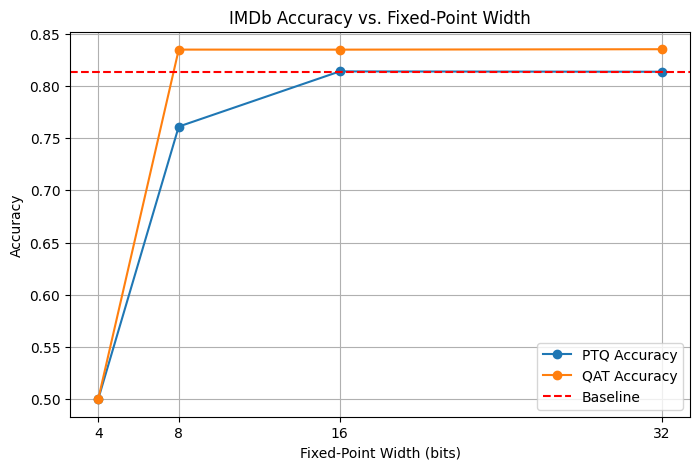

In [16]:
import matplotlib.pyplot as plt

baseline = 0.8136
# ptq_accuracies = [0.5, 0.80272, 0.82164, 0.82084]
# qat_accuracies = [0.5, 0.83148, 0.83392, 0.83428]
print(ptq_accuracies)
print(qat_accuracies)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bit_widths, ptq_accuracies, marker='o', label='PTQ Accuracy')
plt.plot(bit_widths, qat_accuracies, marker='o', label='QAT Accuracy')

# Add baseline as a horizontal line
plt.axhline(y=baseline, color='r', linestyle='--', label='Baseline')

# Labeling and styling
plt.title("IMDb Accuracy vs. Fixed-Point Width")
plt.xlabel("Fixed-Point Width (bits)")
plt.ylabel("Accuracy")
plt.xticks(bit_widths)
plt.legend()
plt.grid(True)
plt.show()

2. **Pruning Exploration (Tutorial 4)**
   - Take your best obtained model from Task 1 and rerun the pruning procedure, varying the sparsity from 0.1 to 0.9.  
   - Plot a figure where:
     - **x-axis:** Sparsity  
     - **y-axis:** Highest achieved accuracy on the IMDb dataset  
     - Follow the procedure in Tutorial 4.  
   - Plot separate curves for **Random** and **L1-Norm** methods to evaluate the effect of different pruning strategies.

In [5]:
import chop.passes as passes
from transformers import AutoModelForSequenceClassification
from chop import MaseGraph
import chop.passes as passes
from pathlib import Path
from chop.tools import get_tokenized_dataset, get_trainer

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [ ]:
pruned_acc_random = []
finetuned_acc_random = []

pruned_acc_l1 = []
finetuned_acc_l1 = []

possible_sparsity = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for strategy in ['l1-norm', 'random']:
    for sparsity in possible_sparsity:
        # load model
        mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_3_qat_32")

        pruning_config = {
            "weight": {
                "sparsity": sparsity,
                "method": strategy,
                "scope": "local",
            },
            "activation": {
                "sparsity": sparsity,
                "method": strategy,
                "scope": "local",
            },
        }

        mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)

        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=5,
        )

        # Evaluate accuracy
        eval_results = trainer.evaluate()
        print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
        if strategy == 'random':
            pruned_acc_random.append(eval_results['eval_accuracy'])
        if strategy == 'l1-norm':
            pruned_acc_l1.append(eval_results['eval_accuracy'])


        # further fine-tunning
        trainer.train()
        eval_results = trainer.evaluate()
        print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
        if strategy == 'random':
            finetuned_acc_random.append(eval_results['eval_accuracy'])
        if strategy == 'l1-norm':
            finetuned_acc_l1.append(eval_results['eval_accuracy'])


/home/jw3621/adls/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_encoder_

Evaluation accuracy: 0.8398


Step,Training Loss
500,0.389800
1000,0.385300
1500,0.394900
2000,0.385200
2500,0.387200
3000,0.392400
3500,0.397800
4000,0.367300
4500,0.360400
5000,0.370000


In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

print(pruned_acc_random)
print(finetuned_acc_random)
print(pruned_acc_l1)
print(finetuned_acc_l1)
# pruned_acc_random, finetuned_acc_random, pruned_acc_l1, finetuned_acc_l1

# 1. Compute the best (maximum) accuracy at each sparsity for both strategies.
best_acc_random = [
    max(p, f) for p, f in zip(pruned_acc_random, finetuned_acc_random)
]
best_acc_l1 = [
    max(p, f) for p, f in zip(pruned_acc_l1, finetuned_acc_l1)
]

# 2. Create the plot.
plt.figure(figsize=(8, 6))
plt.plot(possible_sparsity, best_acc_random, marker='o', label='Random')
plt.plot(possible_sparsity, best_acc_l1, marker='s', label='L1-Norm')

plt.xlabel('Sparsity')
plt.ylabel('Highest Achieved Accuracy')
plt.title('Comparison of Random vs. L1-Norm Pruning Strategies')
plt.legend()
plt.grid(True)

plt.savefig(f"{Path.home()}/prune_plot", dpi=300)

plt.show()


In [1]:
from pathlib import Path
print(f"{Path.home()}/prune_plot")

/home/jw3621/prune_plot


In [ ]:
import os
os._exit(0)